In [ ]:
from aicsimageio import AICSImage
import napari
from aicsimageio.readers import CziReader
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Load the image
reader = CziReader("extern_Synlab_2156_17_3_MTB.czi")
# Get whole image
smear = reader.get_image_data("MYX", C=0)

In [199]:
# save in a new variable the information regarding the 673th tile out of 1345
img = smear[674]
img.shape

print(img.shape)
print(np.max(img))
print(np.min(img))

(2048, 1504)
16414
104


In [200]:
# rescale the image to 0-255
def rescale(image: np.ndarray):
    """
    :param image: to  be rescaled
    :return: rescaled image
    """
    return (image - np.min(image)) / (np.max(image) - np.min(image)) * 255

# visualize the image with napari using its numpy array
def visualize_napari(numpy_img: np.ndarray,name):
    """
    :param numpy_img: image to be visualized
    """
    with napari.gui_qt():
        viewer = napari.Viewer()
        viewer.add_image(numpy_img,name=name)

# visualize different images in the same moment
def visualize_all_list_napari(numpy_img_list: np.ndarray,names):
    """
    :param numpy_img_list: list containing different images to be visualized
    """
    with napari.gui_qt():
        viewer = napari.Viewer()
        for i, img in enumerate(numpy_img_list):
            viewer.add_image(img, name=names[i] )

# plot histogram of pixel intensity
def plot_histogram(image: np.ndarray):
    plt.hist(image.ravel(),image.max(),[0,image.max()])
    plt.show()


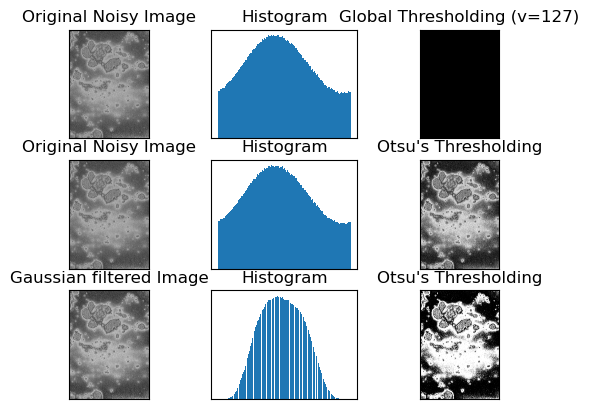

In [8]:
# different thresholding methods example from opencv documentation.

# global thresholding
ret1,th1 = cv.threshold(img,5000,255,cv.THRESH_BINARY)
# manually setting the global threshold value therefore not automatic / the optimal value / the optimal choice
# Otsu's thresholding
ret2,th2 = cv.threshold(img,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
# Otsu's thresholding after Gaussian filtering
blur = cv.GaussianBlur(img,(5,5),0)
# blur is not really helping us here because we are looking for the opposite task.
ret3,th3 = cv.threshold(blur,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
# plot all the images and their histograms
images = [img, 0, th1,
          img, 0, th2,
          blur, 0, th3]
titles = ['Original Noisy Image','Histogram','Global Thresholding (v=127)',
          'Original Noisy Image','Histogram',"Otsu's Thresholding",
          'Gaussian filtered Image','Histogram',"Otsu's Thresholding"]
for i in range(3):
    plt.subplot(3,3,i*3+1),plt.imshow(images[i*3],'gray')
    plt.title(titles[i*3]), plt.xticks([]), plt.yticks([])
    plt.subplot(3,3,i*3+2),plt.hist(images[i*3].ravel(),256)
    plt.title(titles[i*3+1]), plt.xticks([]), plt.yticks([])
    plt.subplot(3,3,i*3+3),plt.imshow(images[i*3+2],'gray')
    plt.title(titles[i*3+2]), plt.xticks([]), plt.yticks([])
plt.show()

#visualize_napari(th1)
img = img.astype('uint8') #sbagliato
#other thresholding methods
img_blur = cv.medianBlur(img,5)
ret,th1 = cv.threshold(img_blur,127,255,cv.THRESH_BINARY)
th2 = cv.adaptiveThreshold(img_blur,255,cv.ADAPTIVE_THRESH_MEAN_C,\
            cv.THRESH_BINARY,11,2)
th3 = cv.adaptiveThreshold(img_blur,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv.THRESH_BINARY,11,2)
titles = ['Original Image', 'Global Thresholding (v = 127)',
            'Adaptive Mean Thresholding', 'Adaptive Gaussian Thresholding']
images = [img, img_blur, th1, th2, th3]

In [201]:
# compute Otsu's thresholding
def otsu_thresholding(image : np.ndarray):
    """
    Threshold and binarize an image using Otsu's method

    :param image: image you want to threshold
    :return: ret: threshold value
              th: binary image
    """
    ret,th = cv.threshold(image,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
    #ret is the computed value of the threshold AND th is the image with the threshold applied
    return ret, th

#compute hard thresholding
def hard_thresholding(image : np.ndarray, threshold : int):
    """
    Implement an hard threshold. Take everything above "threshold" to be white
    and everything below "threshold" to be black

    :param image: image to be thresholded
    :param threshold: hard threshold to be implemented
    :return: ret: threshold value
              th: binary image
    """
    ret,th = cv.threshold(image,threshold,255,cv.THRESH_BINARY)
    return ret, th

# approach for going through the different tiles and applying the thresholding separately
# split the whole images into tiles
def split_into_tiles(image : np.ndarray, tile_size: int):
    """
    split image into tiles of shape tile_size*tile_size

    :param image: image to be split
    :param tile_size: dimensions of single tiles
    :return: tiles: list with the different tiles
    """
    tiles = []
    for i in range(0, image.shape[0], tile_size):
        for j in range(0, image.shape[1], tile_size):
            tile = image[i:i+tile_size, j:j+tile_size]
            tiles.append(tile)
    return tiles

# approach in which we sharp (instead of blur as the example) the image before applying the thresholding
# sharpen the image using a high-pass filter TODO: can we do this better? sharp out better maybe in sub-images?
def sharpen(image: np.ndarray):
    """
    :param image: image to be sharpened
    :return: sharp image
    """
    kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
    return cv.filter2D(image, -1, kernel)

# change np array to uint8 ATTENTION: in uint8 only numbers until 2^7 can be stored
def to_uint8(image: np.ndarray):
    return np.uint8(image)


def find_coordinates(image: np.ndarray):  #old version
    """
    Find the coordinates of the connected compenents of the image.
    to be more specific, find first coordinate of a component

    :param image: image where we want to find the connected components
    :return: coordinates: array with coordinates of the components in the rows
    """
    num_conn_comp, labels_conn_comp = cv.connectedComponents(image)
    #num_conn_comp tells us how many components we have
    #labels_conn_comp is an image where the entries where there should be
    # a component are the label of that component
    # overwritten in such a way that the the values of the pixels are the value of the corresponding connected component.
    labels_conn_comp = labels_conn_comp.astype(np.uint64)    #cannot use uint8 cannot rappresent all numbers with uint8

    #save coordinates in two dimensional array
    coordinates = np.zeros((num_conn_comp,2),dtype="int64")

    # iterate over the connected components and add the coordinates of the pixels to the list of coordinates
    for i in range(1, num_conn_comp):
        coordinates[i,0] = np.where(labels_conn_comp == i)[0][0]
        coordinates[i,1] = np.where(labels_conn_comp == i)[1][0]

    return coordinates

#connectedComponentsWithStats works better, can get centroid, in this way can put the box/rectangle around the bacilli
#but not all conncected components are identified, might be a problem of the image we give him
def get_connected_components_coordinate(img):
    connectivity = 8
    #find connected components
    num_labels, labels_im, stats, centroids = cv.connectedComponentsWithStats(img, connectivity)
    #get coordinates of connected components
    coordinates = np.zeros((num_labels, 2),dtype=np.uint64)  #NO uint8
    
    for i in range(1, num_labels):
        coordinates[i,0] = centroids[i,0]
        coordinates[i,1] = centroids[i,1]
    #print(coordinates)
    coordinates = coordinates[1:,:]
    return coordinates, centroids

# add the 2d bounding boxes to the image
def add_bounding_boxes(image, coordinates):
    """
    Add white rectangles around bacilli

    :param image: image with bacilli to be boxed
    :param coordinates:  coordinates of the center of the bacillus
    """
    for i in range(len(coordinates)):
            x = coordinates[i][0]
            #x_max = coordinates[i][0]
            y = coordinates[i][1]
            #y_max = coordinates[i][1]
            cv.rectangle(image, (y+15, x+15), (y-15, x-15), (255, 0, 0), 2)

# plot centroids in images to see if they are correct
def plot_centroids(image, centroids):
    """
    plot centroids in image to see if they are correct

    :param image: image with bacilli to be boxed
    :param centroids:  coordinates of the center of the bacillus
    """
    for i in range(len(centroids)):
            x = centroids[i][0]
            y = centroids[i][1]
            cv.circle(image, (int(y), int(x)), 1, (46, 32, 200), 2)

#reconstruct image from different tiles given the number of tiles in x and y direction and a list of tiles
def reconstruct_image(tiles: list, x_tiles: int, y_tiles: int):
    """
    :param tiles:    list with the different single tiles
    :param x_tiles:  how many tiles fit in the x axis
    :param y_tiles:  how many tiles fit in the y axis
    :return:         numpy array, reconstructed image
    """
    big_image = np.zeros((x_tiles*tiles[0].shape[0], y_tiles*tiles[0].shape[1]))
    for i in range(x_tiles):
        for j in range(y_tiles):
            big_image[i*tiles[0].shape[0]:(i+1)*tiles[0].shape[0], j*tiles[0].shape[1]:(j+1)*tiles[0].shape[1]] = tiles[i*y_tiles+j]
    return big_image

#find connected components with specified size with opencv using connectedComponentsWithStats
#does not seem to work very good, maybe we do it by hand...
#could also try with length
def get_connected_components_with_minimum_and_max_size(img: np.ndarray, min_size: int,max_size: int):
    """
    :param img: image where we want to find connected components. black and white immage with
                int8 rappr.
    :param min_size: minimum size of the cc
    :param max_size: maximum size of the cc
    :return:
    """
    #connecctivity shoud tell us about how connected to they have to be to be considered as one, seems to be working poorly
    connectivity = 8
    #find connected components
    num_labels, labels_im, stats, centroids = cv.connectedComponentsWithStats(img, connectivity)
    #get coordinates of connected components
    coordinates =np.array([[0,0]],dtype=np.uint64)
    print(centroids.shape)
    for i in range(1, num_labels):
        if stats[i,4] > min_size and stats[i,4]< max_size:
            coordinates=np.append(coordinates,[centroids[i,:]], axis=0)
    coordinates=coordinates[1:,:]
    return coordinates

#if a black pixel is surrounded by white pixels left right up and down we set it to white, for every pixel in the image
#to help the connected component function, maybe we can improve this
def remove_black_pixels_in_white(img: np.ndarray):
    """
    :param img: image to be better
    :return:    better immage with less black holes in white parts
    """
    #what is white? 255 or what?
    max=img.max()
    #init return image
    ret_img=np.zeros((img.shape[0],img.shape[1]))

    for i in range(1,img.shape[0]-1):
        for j in range(1,img.shape[1]-1):
            if img[i,j] == 0:
                if img[i-1,j] > 0 or img[i+1,j] > 0 or img[i,j-1] > 0 or img[i,j+1] > 0:
                    ret_img[i,j] = max
                else:
                    ret_img[i,j]=img[i,j]
    return ret_img


In [202]:
img_sharpened = sharpen(img)
_, otsu_thesh_sharp = otsu_thresholding(img_sharpened)
_, otsu_thresh_orig = otsu_thresholding(img)
_, sharpened_hard_trhesh = hard_thresholding(img_sharpened, 7000)
images = [img, img_sharpened, otsu_thesh_sharp, otsu_thresh_orig, sharpened_hard_trhesh]

visualize_all_list_napari(images,["original","shapened","otsu on sharpened","otsu on orig","hard tresh 7000"])

c:\Users\marin\anaconda3\envs\env\lib\site-packages\napari\_qt\qt_event_loop.py:284: FutureWarning: 
The 'gui_qt()' context manager is deprecated.
If you are running napari from a script, please use 'napari.run()' as follows:

    import napari

    viewer = napari.Viewer()  # no prior setup needed
    # other code using the viewer...
    napari.run()

In IPython or Jupyter, 'napari.run()' is not necessary. napari will automatically
start an interactive event loop for you: 

    import napari
    viewer = napari.Viewer()  # that's it!

  warn(


In [11]:
def hard_thresholding_shit_boxes(img: np.ndarray):
    """
    Implement tresholding with a hard treshold (10000).
    Find components and box coordinates, draw the boxes with
    first coordinate of the cc.

    :param img: image to be tresholded
    """
    #sharpen image
    sharpened_img = sharpen(img)
    #hard threshold the sharpened image 10000
    threshold, hard_threshold = hard_thresholding(sharpened_img, 6000)
    #convert to uint8 s. t. coonected  component function can accept it
    hard_threshold=to_uint8(hard_threshold)
    #find coordinates of connected components, first coordinate, shit because not centered
    coordinates= get_connected_components_coordinate(hard_threshold)
    #add bounding boxes to the image
    add_bounding_boxes(hard_threshold, coordinates)
    #visualize
    visualize_all_list_napari([hard_threshold, sharpened_img, img],["hard tresh 7000","shapened","orig"])

In [15]:
#sharpen image
sharpened_img = sharpen(img)
#hard threshold the sharpened image 10000
threshold, hard_threshold = hard_thresholding(sharpened_img, 6000)
#convert to uint8 s. t. coonected  component function can accept it
hard_threshold=np.uint8(hard_threshold)
#find coordinates of connected components, first coordinate, shit because not centered
coordinates, centroids= get_connected_components_coordinate(hard_threshold)
#add bounding boxes to the image
plot_centroids(hard_threshold, centroids)
visualize_napari(hard_threshold, "hard tresh 6000")
coordinates = np.int64(coordinates)
#print(coordinates)
add_bounding_boxes(hard_threshold, coordinates)

c:\Users\marin\anaconda3\envs\env\lib\site-packages\napari\_qt\qt_event_loop.py:284: FutureWarning: 
The 'gui_qt()' context manager is deprecated.
If you are running napari from a script, please use 'napari.run()' as follows:

    import napari

    viewer = napari.Viewer()  # no prior setup needed
    # other code using the viewer...
    napari.run()

In IPython or Jupyter, 'napari.run()' is not necessary. napari will automatically
start an interactive event loop for you: 

    import napari
    viewer = napari.Viewer()  # that's it!

  warn(


In [ ]:
def otsu_split_thresholding(img: np.ndarray, tile_size = 32):
    """
    Perform Otsu tresholding on sub images of 32 x 32,
    then reconstruct

    :param img:  image to be tresholded
    """
    #sharpen image
    sharpened_img = sharpen(img)
    #split
    tiles_sharpened=split_into_tiles(sharpened_img, tile_size)
    tiles=split_into_tiles(img,tile_size)
    #without sharpening
    thresholded_tiles_sharp=[]
    for t in tiles_sharpened:
        r,th=otsu_thresholding(t)
        thresholded_tiles_sharp.append(th)

    return thresholded_tiles_sharp


#reconstruct
reconstructed_image_sharp_32=reconstruct_image(otsu_split_thresholding(img),64,47)
#otsu on sub-images
reconstructed_image_sharp_16=reconstruct_image(otsu_split_thresholding(img,16),128,94)

#reconstructed_image_sharp_8=reconstruct_image(otsu_split_thresholding(img,8),256,188)

sharpened_img = sharpen(img)

#visualize
visualize_all_list_napari([reconstructed_image_sharp_32,reconstructed_image_sharp_16, sharpened_img,img],["sharpend reconstruton 32","sharpend reconstruton 16", "sharped","orig"])

now we are getting the tiles 16x16 that contains bacilli very well, but of course the background is difuse and messy because of the otsu threshold.


Okay, approach: connected components.

In [21]:
tile0 = np.uint8(otsu_split_thresholding(img,16)[0])
num0,img_16_0 = cv.connectedComponents(tile0)
print(num0)

#tiles=otsu_split_thresholding(img,16)
#for tile in tiles:
#    print(tile)
    #tile_uint8=np.unit8(tile)
    #num,img=cv.connectedComponents(tile_uint8)
    #print(num)

22


In [22]:
img_16_0

array([[ 1,  1,  0,  2,  0,  0,  0,  4,  0,  0,  0,  0,  0,  6,  0,  0],
       [ 0,  0,  0,  0,  0,  3,  0,  0,  4,  0,  5,  0,  0,  0,  0,  7],
       [ 8,  0,  0,  3,  0,  0,  3,  0,  4,  0,  0,  5,  0,  5,  0,  7],
       [ 8,  8,  0,  3,  3,  3,  0,  0,  0,  0,  0,  0,  5,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  5,  0,  0,  0],
       [ 0,  0,  9,  0,  0, 10,  0,  0, 11, 11, 11,  0,  0,  0, 12,  0],
       [ 0,  9,  0,  9,  0, 10,  0, 11,  0,  0,  0, 11,  0,  0,  0,  0],
       [ 0,  0,  0,  9,  0,  0,  0,  0, 11, 11,  0,  0,  0,  0,  0,  0],
       [ 0, 13,  0,  9,  0,  0,  0,  0,  0, 11,  0,  0,  0,  0, 15,  0],
       [13,  0,  0,  0,  0, 11, 11, 11, 11,  0,  0, 14,  0,  0, 15,  0],
       [ 0,  0, 16, 16,  0, 11, 11,  0,  0, 11,  0,  0,  0, 15,  0, 15],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 11, 11,  0, 17,  0,  0,  0,  0],
       [ 0,  0, 18, 18,  0, 19,  0,  0,  0, 11,  0,  0, 17, 17, 17,  0],
       [ 0,  0,  0,  0,  0, 19,  0,  0,  0, 11,  0,

In [23]:
16*16

256

In [32]:
#recognise the tiles 16x16 with less connected components
def tiles_with_less_connected_components(tile: np.ndarray):
    """
    :param tile:   tile to be checked
    :param threshold:   threshold for connected components
    :return:    false if it has a bacilli, true if it has no bacilli
    """
    #convert to uint8
    tile_uint8 = np.uint8(tile)
    #find connected components
    num_cc,img_16_cc = cv.connectedComponents(tile_uint8)
    #if less than threshold
    if num_cc == 1: #it has bacilli because it is all background (black)
        return False
    else:
        return True

The approach of the connected components is not working because inputtting the threshold manually is not working. We can not get how many connected components the bacilli tiles are going to have. 

In [33]:
#invert binary image
def invert_binary_image(img: np.ndarray):
    """
    :param img: image to be inverted
    :return:    inverted image
    """
    return 255-img

we can consider this approach. trying to get the connected component to recognise the background as the only conncected compoenetn when the bacilli is there. 

In [45]:
#check if image is to be set to 0, if we have more than 400 pixels with value 0 or less then 600 pixels with value 0 we set the image to 0
def check_image(img: np.ndarray):
    """
    For every sub-image we check if its worth keeping or not

    :param img: image to be checked
    :return: bool
    """
    
    if np.sum(img == 0) > 215: #we have a bacilli
        return False
    else:
        return True

#set pixels that are 255 to zero (black)
def set_zero(img):
    h=img
    h[h>0]=0
    return h


In [173]:
def otsu_cleaned_split_thresholding(img):
    """
    Performed otsu on an immage that was cleaned in white

    :param img: image to be tresholded
    :return:    tresholded clean image
    """
    #sharpen image
    sharpened_img= sharpen(img)

    #split
    tiles=split_into_tiles(sharpened_img,16)

    #list with the thresholded tiles size 16x16
    thresholded_tiles = otsu_split_thresholding(img,16)

    #reconstruct
    reconstructed_image=reconstruct_image(thresholded_tiles,128,94)

    #clean
    cleaned_tiles=[]
    for tl in thresholded_tiles:
        if check_image(tl):
            #print("im cleaning")
            m=set_zero(tl)
            cleaned_tiles.append(m)
        else:
            cleaned_tiles.append(tl)
    
    #reconstruct
    reconstructed_clean_image=reconstruct_image(cleaned_tiles,128,94)

    #final cleaning
    #final_cleaned_image = (reconstructed_clean_image)

    #visualize
    visualize_all_list_napari([reconstructed_image, reconstructed_clean_image,sharpened_img,img], ["reconstructed_image","reconstructed_clean_image","sharpened_img","img"])
    
    return reconstructed_clean_image

cleaned = otsu_cleaned_split_thresholding(img)


c:\Users\marin\anaconda3\envs\env\lib\site-packages\napari\_qt\qt_event_loop.py:284: FutureWarning: 
The 'gui_qt()' context manager is deprecated.
If you are running napari from a script, please use 'napari.run()' as follows:

    import napari

    viewer = napari.Viewer()  # no prior setup needed
    # other code using the viewer...
    napari.run()

In IPython or Jupyter, 'napari.run()' is not necessary. napari will automatically
start an interactive event loop for you: 

    import napari
    viewer = napari.Viewer()  # that's it!

  warn(


In [176]:
a_bit_of_shit_in_our_bacilli_tiles = cleaned.copy()

In [177]:
np.uint8(cleaned)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [178]:
num_labels, labels_im, stats, centroids = cv.connectedComponentsWithStats(np.uint8(cleaned), connectivity=8)
print(num_labels)
print(centroids)
print(stats) #x,y,w,h,area

168
[[ 751.51288728 1023.60129113]
 [ 152.           54.73333333]
 [1117.9375       68.875     ]
 [1124.8          68.6       ]
 [1188.9375       90.875     ]
 [ 290.16666667  102.        ]
 [1468.          113.        ]
 [1204.33333333  120.73333333]
 [1470.5         123.        ]
 [1259.52        178.6       ]
 [  78.41176471  191.29411765]
 [1078.5         189.        ]
 [  90.70588235  197.41176471]
 [  68.          198.        ]
 [  74.          198.        ]
 [  78.          198.        ]
 [  79.          202.        ]
 [1191.16666667  211.75      ]
 [1293.71428571  227.85714286]
 [ 733.25        230.20833333]
 [ 722.46153846  260.07692308]
 [ 625.          268.1       ]
 [ 465.84615385  298.38461538]
 [ 276.18181818  300.68181818]
 [ 936.30769231  319.61538462]
 [ 899.96        328.8       ]
 [ 908.66666667  331.66666667]
 [ 905.5         332.        ]
 [ 907.5         335.        ]
 [1006.48484848  338.51515152]
 [1018.          336.        ]
 [1017.          339.        ]
 [10

removing the area 1 cc

In [179]:
# put to black connected components which area is equal to 1
def clean_connected_components(img: np.ndarray):
    """
    :param img: image to be cleaned
    :return:    cleaned image
    """
    #find connected components
    num_labels, labels_im, stats, centroids = cv.connectedComponentsWithStats(np.uint8(img), connectivity=8)
    #print(num_labels)
    #print(centroids)
    #print(stats) #x,y,w,h,area
    #put to black connected components which area is equal to 1 or 2
    for i in range(1, num_labels):
        if stats[i][4] < 3:
            img[labels_im == i] = 0
    return img


In [180]:
cleaning_the_shit_on_the_bacilli_tiles = clean_connected_components(cleaned)

In [181]:
num_labels, labels_im, stats, centroids = cv.connectedComponentsWithStats(np.uint8(cleaning_the_shit_on_the_bacilli_tiles), connectivity=8)
print(num_labels)
print(centroids)
print(stats) #x,y,w,h,area

126
[[ 751.51450184 1023.59491476]
 [ 152.           54.73333333]
 [1117.9375       68.875     ]
 [1124.8          68.6       ]
 [1188.9375       90.875     ]
 [ 290.16666667  102.        ]
 [1204.33333333  120.73333333]
 [1470.5         123.        ]
 [1259.52        178.6       ]
 [  78.41176471  191.29411765]
 [1078.5         189.        ]
 [  90.70588235  197.41176471]
 [1191.16666667  211.75      ]
 [1293.71428571  227.85714286]
 [ 733.25        230.20833333]
 [ 722.46153846  260.07692308]
 [ 625.          268.1       ]
 [ 465.84615385  298.38461538]
 [ 276.18181818  300.68181818]
 [ 936.30769231  319.61538462]
 [ 899.96        328.8       ]
 [ 908.66666667  331.66666667]
 [1006.48484848  338.51515152]
 [1009.5         342.875     ]
 [ 956.96        379.28      ]
 [ 164.5         401.75      ]
 [ 888.875       435.25      ]
 [1491.33333333  457.77777778]
 [ 980.57142857  458.57142857]
 [1482.          460.75      ]
 [1487.77777778  461.55555556]
 [1487.94117647  466.17647059]
 [11

In [193]:
visualize_all_list_napari([cleaning_the_shit_on_the_bacilli_tiles, a_bit_of_shit_in_our_bacilli_tiles], ["cleaned", "thresholded"])

c:\Users\marin\anaconda3\envs\env\lib\site-packages\napari\_qt\qt_event_loop.py:284: FutureWarning: 
The 'gui_qt()' context manager is deprecated.
If you are running napari from a script, please use 'napari.run()' as follows:

    import napari

    viewer = napari.Viewer()  # no prior setup needed
    # other code using the viewer...
    napari.run()

In IPython or Jupyter, 'napari.run()' is not necessary. napari will automatically
start an interactive event loop for you: 

    import napari
    viewer = napari.Viewer()  # that's it!

  warn(


In [183]:
#plot coordinates of the stats in the image
def plot_stats(img: np.ndarray, stats: np.ndarray):
    """
    :param img: image to be plotted
    :param stats:   stats of the image
    :return:    plotted image
    """
    #plot the centroids
    for i in range(1, len(stats)):
        x = stats[i][0]
        y = stats[i][1]
        cv.circle(img, (x, y), 10, (3,168,158), -1)
    return img    


In [184]:
#img_with_stats_coordinates = plot_stats(actual_bacicilli, stats)
#visualize_napari(img_with_stats_coordinates, "img_with_coordinates")

we are actually covering the bacilli so the statts coordinates are the ones to put as a center of the boxes

In [190]:
bacilli = cleaned.copy()

In [191]:

# add the 2d bounding boxes to the image
def add_bounding_boxes(image, coordinates):
    """
    Add white rectangles around bacilli

    :param image: image with bacilli to be boxed
    :param coordinates:  coordinates of the center of the bacillus
    """
    for i in range(1,len(coordinates)):
            x = coordinates[i][0] - 5
            #x_max = coordinates[i][0]
            y = coordinates[i][1] - 5
            #y_max = coordinates[i][1]
            h=coordinates[i][3]
            w=coordinates[i][2]
            cv.rectangle(image, (x, y), (x+w+10, y+h+10), (255, 0, 0), 1)
    return image



In [192]:
box_bacilli = add_bounding_boxes(bacilli, stats)
visualize_all_list_napari([box_bacilli, cleaned, img], ["box_bacilli", "bacilli", "og"])

c:\Users\marin\anaconda3\envs\env\lib\site-packages\napari\_qt\qt_event_loop.py:284: FutureWarning: 
The 'gui_qt()' context manager is deprecated.
If you are running napari from a script, please use 'napari.run()' as follows:

    import napari

    viewer = napari.Viewer()  # no prior setup needed
    # other code using the viewer...
    napari.run()

In IPython or Jupyter, 'napari.run()' is not necessary. napari will automatically
start an interactive event loop for you: 

    import napari
    viewer = napari.Viewer()  # that's it!

  warn(
